In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Prompt: 

### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, 
### identify which factors predict future user adoption.

Strategy:

1. Get the data
2. First segment the adopted based on business definition
3. Then use correlation matrix to see which features have best signal for adoption
4. Make new features to get better signal for adoption?

# Data

## Dictionary:
Users table with data on 12,000 users who signed up for the product in the last two years.  This table includes: 
* name: the user's name
-object_id: the user's id
-email: email address 
-creation_source: how their account was created. This takes on one of 5 values:
	PERSONAL_PROJECTS: invited to join another user's personal workspace
	GUEST_INVITE: invited to an organization as a guest (limited permissions)
	ORG_INVITE: invited to an organization (as a full member)
	SIGNUP: signed up via asana.com
	SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
-creation_time: when they created their account
-last_session_creation_time: unix timestamp of last login
-opted_in_to_mailing_list: whether they have opted into receiving marketing emails
-enabled_for_marketing_drip: whether they are on the regular marketing email drip
-org_id: the organization (group of users) they belong to
-invited_by_user_id: which user invited them to join (if applicable).

A usage summary user engagement table that has a row for each day that a user logged into the product. 

In [2]:
users = pd.read_csv('/kaggle/input/relax-datachallenge/takehome_users.csv', encoding='latin_1')
user_engagement = pd.read_csv('/kaggle/input/relax-datachallenge/takehome_user_engagement.csv', encoding='latin_1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


1. get the week for each timestamp
2. then count each week per user_id
3. filter on >=3 engagements for each week for each user as adopted

Loaded users and user engagement tables into Postgres. Got adopted users based on business definition and joined back to users. With resultant table, got user information as well as those who adopted/not adopted the product.

In [5]:
users = pd.read_csv('/kaggle/input/adopted-users3/adopted_users.csv')
users.head()

,user_id,creation_time,creation_time_date,creation_time_year,creation_time_month,creation_time_dow,name,email,creation_source,last_session_creation_time,last_session_creation_time_year,last_session_creation_time_month,last_session_creation_time_dow,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,2.0,2013-11-15 03:45:04,2013-11-15,2013,11,5,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 20:45:04-07,2014.0,3.0,7.0,0,0,1,316.0,1
1,10.0,2013-01-16 22:08:03,2013-01-16,2013,1,3,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 15:08:03-07,2014.0,6.0,2.0,1,1,318,4143.0,1
2,20.0,2014-03-06 11:46:38,2014-03-06,2014,3,4,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 04:46:38-07,2014.0,5.0,4.0,0,0,58,NaN,1
3,33.0,2014-03-11 06:29:09,2014-03-11,2014,3,2,Araujo Josй,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,2014-05-30 23:29:09-07,2014.0,5.0,5.0,0,0,401,79.0,1
4,42.0,2012-11-11 19:05:07,2012-11-11,2012,11,7,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 12:05:07-07,2014.0,5.0,7.0,1,0,235,NaN,1


To answer the question: which factors predict future user adoption we can look at the data provided **and think about other data that we can gather that would help see common customer actions leading to adoption.**

Look at common engagement metrics for SaaS company.
* From this dataset:
1. Stickiness
1. Virality
1. how they got to platform
1. adopted come from same org/marketing drip?

Outside of this dataset:
1. what are they doing in Asana app
1. measuring lingering time and giving threshold on what is good/bad lingering time
1. specific features being used more vs others
1. feature they only use/feature they never use?
1. did they return on their own or via a push notification/email


# Exploratory Data Analysis 

In [6]:
users['adopted'].value_counts()

0    10555
1     1445
Name: adopted, dtype: int64

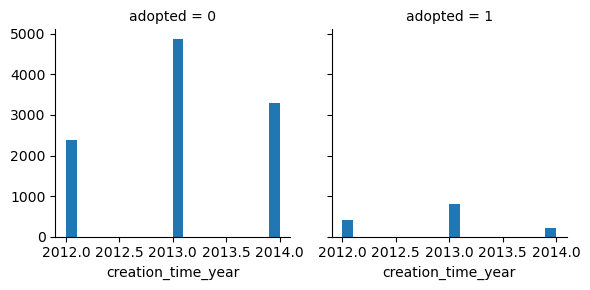

In [7]:
g = sns.FacetGrid(users, col='adopted')
g.map(plt.hist, 'creation_time_year', bins=20)

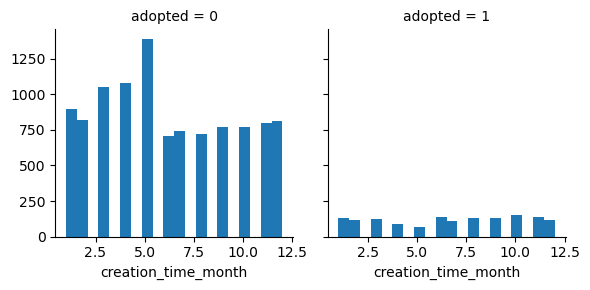

In [8]:
g = sns.FacetGrid(users, col='adopted')
g.map(plt.hist, 'creation_time_month', bins=20)

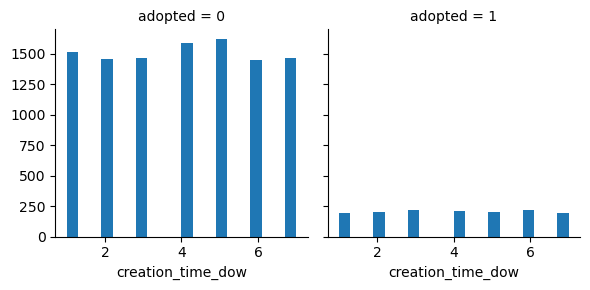

In [9]:
g = sns.FacetGrid(users, col='adopted')
g.map(plt.hist, 'creation_time_dow', bins=20)

Nothing too interesting setting adopted apart from non-adopted besides non-adopted spiking in May.

In [10]:
users.groupby(['adopted', 'creation_source']).size()

adopted  creation_source   
0        GUEST_INVITE          1837
         ORG_INVITE            3763
         PERSONAL_PROJECTS     1964
         SIGNUP                1812
         SIGNUP_GOOGLE_AUTH    1179
1        GUEST_INVITE           326
         ORG_INVITE             491
         PERSONAL_PROJECTS      147
         SIGNUP                 275
         SIGNUP_GOOGLE_AUTH     206
dtype: int64

Looks like most adopted came from invites. 

_______________________________

# Describing Data

In [11]:
#On top of referring to data dictionary from above, we can start with describing data with:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           1445 non-null   float64
 1   creation_time                     12000 non-null  object 
 2   creation_time_date                12000 non-null  object 
 3   creation_time_year                12000 non-null  int64  
 4   creation_time_month               12000 non-null  int64  
 5   creation_time_dow                 12000 non-null  int64  
 6   name                              12000 non-null  object 
 7   email                             12000 non-null  object 
 8   creation_source                   12000 non-null  object 
 9   last_session_creation_time        8823 non-null   object 
 10  last_session_creation_time_year   8823 non-null   float64
 11  last_session_creation_time_month  8823 non-null   float64
 12  last

**Which features are categorical?
These values classify the samples into sets of similar samples.
Within categorical features are:**

1. nominal
1. ordinal
1. ratio
1. interval-based

Defining this also helps us determining which plots to use to visualize data.

* So for this dataset, the categorical are: adopted, creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id**


** Which features are numerical? These values change from sample to sample. Within numerical features are: **
1. discrete
1. continuous
1. timeseries based

Defining these also help us choose the apporpriate plots for visualization.

* For this dataset, the continuous variables are: creation_time and its derivatives, last_session_creation_time

**Which features are mixed data types?**

These features are numerical, alphanumeric data within the same feature. These would be candidates for correcting data stage.

* We luckily don't have any of these in our sample dataset.

**Which features may contain errors or typos?**

This sort of data would have inconsistent patterns in data such as a name column with titles, punctuation where it is not supposed to be, quotes for aliases, etc.

* Fortunately, this dataset does not have any of those sort of features.


**Which features would contain blank, null or empty?**

These would require correcting.

In [12]:
users.isnull().sum()

user_id                             10555
creation_time                           0
creation_time_date                      0
creation_time_year                      0
creation_time_month                     0
creation_time_dow                       0
name                                    0
email                                   0
creation_source                         0
last_session_creation_time           3177
last_session_creation_time_year      3177
last_session_creation_time_month     3177
last_session_creation_time_dow       3177
opted_in_to_mailing_list                0
enabled_for_marketing_drip              0
org_id                                  0
invited_by_user_id                   5583
adopted                                 0
dtype: int64

last_session_creation_time (and its derviatives) and invited_by_user_id have NULL values.

**Data types for various features:**

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           1445 non-null   float64
 1   creation_time                     12000 non-null  object 
 2   creation_time_date                12000 non-null  object 
 3   creation_time_year                12000 non-null  int64  
 4   creation_time_month               12000 non-null  int64  
 5   creation_time_dow                 12000 non-null  int64  
 6   name                              12000 non-null  object 
 7   email                             12000 non-null  object 
 8   creation_source                   12000 non-null  object 
 9   last_session_creation_time        8823 non-null   object 
 10  last_session_creation_time_year   8823 non-null   float64
 11  last_session_creation_time_month  8823 non-null   float64
 12  last

**Distribution of numerical features values across samples.**

This helps us determine how representative the sample dataset is of the actual problem domain (assuming there is already some domain expertise. maybe some common sense can help with comparison).

In [14]:
users[['user_id', 'creation_time_year', 'creation_time_month', 'creation_time_dow', 'last_session_creation_time_year', 'last_session_creation_time_month', 'last_session_creation_time_dow', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted']].describe()

,user_id,creation_time_year,creation_time_month,creation_time_dow,last_session_creation_time_year,last_session_creation_time_month,last_session_creation_time_dow,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
count,1445.000000,12000.000000,12000.000000,12000.000000,8823.000000,8823.000000,8823.000000,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6070.540484,2013.060833,6.250833,3.998167,2013.243001,6.081945,3.925309,0.249500,0.149333,141.884583,5962.957145,0.120417
std,3495.859365,0.723424,3.423968,1.981243,0.737090,3.143723,1.982975,0.432742,0.356432,124.056723,3383.761968,0.325462
min,2.000000,2012.000000,1.000000,1.000000,2012.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3066.000000,2013.000000,3.000000,2.000000,2013.000000,4.000000,2.000000,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6096.000000,2013.000000,6.000000,4.000000,2013.000000,5.000000,4.000000,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9195.000000,2014.000000,9.000000,6.000000,2014.000000,9.000000,6.000000,0.000000,0.000000,238.250000,8817.000000,0.000000
max,11988.000000,2014.000000,12.000000,7.000000,2014.000000,12.000000,7.000000,1.000000,1.000000,416.000000,11999.000000,1.000000


* Total samples: 12000
* adopted is a categorical feature with 0 / 1 values
* Approximately 12% adopted
* Average 24% of sample size have opted into mailing list
* Average 14% allowed marketing to contact them

**What is the distribution of categorical features?**

In [15]:
users.describe(include=['O'])

,creation_time,creation_time_date,name,email,creation_source,last_session_creation_time
count,12000,12000,12000,12000,12000,8823
unique,11996,730,11355,11980,5,8821
top,2012-09-14 21:35:03,2014-05-30,Cavalcanti Victor,AlfieLane@yahoo.com,ORG_INVITE,2014-06-04 00:46:58-07
freq,2,71,5,2,4254,2
